# Uncertainty plot

In [323]:
subcortical_regions = [
    "Thalamus",
    "Caudate",
    "Putamen",
    "Pallidum",
    "Hippocampus",
    "Amygdala",
    "Accumbens-area",
]
subcortical_regions = (
    ["Left-" + region for region in subcortical_regions]
    + ["Right-" + region for region in subcortical_regions]
    + subcortical_regions
)

# Cortical regions in DKT atlas
cortical_regions = [
    "bankssts",
    "caudalanteriorcingulate",
    "caudalmiddlefrontal",
    "cuneus",
    "entorhinal",
    "fusiform",
    "inferiorparietal",
    "inferiortemporal",
    "isthmuscingulate",
    "lateraloccipital",
    "lateralorbitofrontal",
    "lingual",
    "medialorbitofrontal",
    "middletemporal",
    "parahippocampal",
    "paracentral",
    "parsopercularis",
    "parsorbitalis",
    "parstriangularis",
    "pericalcarine",
    "postcentral",
    "posteriorcingulate",
    "precentral",
    "precuneus",
    "rostralanteriorcingulate",
    "rostralmiddlefrontal",
    "superiorfrontal",
    "superiorparietal",
    "superiortemporal",
    "supramarginal",
    "frontalpole",
    "temporalpole",
    "transversetemporal",
    "insula",
]
cortical_regions = (
    ["lh-" + region for region in cortical_regions]
    + ["rh-" + region for region in cortical_regions]
    + cortical_regions
)

In [324]:
import plotly.express as px
import pandas as pd
import numpy as np
from pathlib import Path

anonymizer = False

root_dir = Path.cwd().parent.parent
# root_dir = Path.cwd() /  "freesurfer-fuzzy" / "notebooks"


def anondir(path: Path, prefix=root_dir) -> Path:
    """Anonymize a directory path by replacing user-specific parts with <root>."""
    if not anonymizer:
        return path
    path_str = str(path).replace(str(prefix), "<living-park>")
    return Path(path_str)


print(f"Running in root dir: {anondir(root_dir)}")
npv_dir = root_dir / "npv" / "csv_all"
print(f"Using NPV dir: {anondir(npv_dir)}")
data_dir = root_dir / "notebooks" / "papers_data"
print(f"Using data dir: {anondir(data_dir)}")

Running in root dir: /home/yohan/Work/livingpark-numerical-variability/freesurfer-fuzzy
Using NPV dir: /home/yohan/Work/livingpark-numerical-variability/freesurfer-fuzzy/npv/csv_all
Using data dir: /home/yohan/Work/livingpark-numerical-variability/freesurfer-fuzzy/notebooks/papers_data


In [325]:
import scipy.stats


def std_p_F(F, df, npv):
    return 2 * np.sqrt(F) * scipy.stats.f.pdf(F, dfn=1, dfd=df) * npv


def std_p_r(r, n, npv):
    t = r * np.sqrt((n - 2) / (1 - r**2))
    return 2 * scipy.stats.t.pdf(np.abs(t), n - 2) * np.sqrt(((n - 2) / (n - 1))) * npv

In [326]:
def nature_style(
    fig,
    marker_size=8,
    opacity=1,
    font_size=14,
    width=800,
    height=800,
    x_range=(-0.05, 1.05),
    y_range=(-0.05, 1.05),
):
    # === Nature style adjustments ===
    fig.update_traces(
        marker=dict(
            size=marker_size, opacity=opacity, line=dict(width=0.25, color="black")
        ),  # clean markers
    )

    fig.update_layout(
        title_text="Probability of False Positive vs Sample Size",
        title_x=0.5,
        width=width,  # ~single-column Nature width
        height=height,
        font=dict(family="Helvetica", size=font_size),
        plot_bgcolor="white",
        paper_bgcolor="white",
        showlegend=True,
        margin=dict(l=60, r=60, t=80, b=60),
        legend=dict(
            x=0.98,
            y=0.98,
            xanchor="right",
            yanchor="top",
            bgcolor="rgba(255, 255, 255, 0.8)",
            bordercolor="black",
            borderwidth=1,
        ),
        xaxis=dict(
            # title="Sample size",
            linecolor="black",
            ticks="outside",
            tickwidth=1,
            tickcolor="black",
            showgrid=False,
            mirror=True,
            range=x_range,
        ),
        yaxis=dict(
            # title="Probability of false positive",
            linecolor="black",
            ticks="outside",
            tickwidth=1,
            tickcolor="black",
            showgrid=False,
            mirror=True,
            range=y_range,
        ),
    )

    fig.update_xaxes(
        showline=True,
        linewidth=1,
        linecolor="black",
        mirror=True,
        ticks="inside",
        categoryorder="array",
    )

    fig.update_yaxes(
        showline=True,
        linewidth=1,
        linecolor="black",
        mirror=True,
        ticks="inside",
    )

In [327]:
import pandas as pd
from scipy.stats import beta
import numpy as np


def beta_params_from_mean_var(mu, var, eps=1e-12):
    """Return (a,b) for Beta by moment matching. Clamps var to < mu(1-mu)."""
    max_var = mu * (1 - mu) - eps
    # Clamp var for non-degenerate cases
    var_clamped = np.minimum(var, max_var)

    # Calculate k for non-degenerate cases
    # Ensure we don't divide by zero if var_clamped becomes zero due to clamping
    # This can happen if mu*(1-mu) is very small and var is also very small but positive.
    # The original code implicitly handles this by setting k=1e6 when var<=0.
    # Here, we ensure that if var_clamped is effectively zero, k is large.
    # A small positive value for the denominator to avoid division by zero for k calculation
    denominator = np.where(var_clamped == 0, eps, var_clamped)
    k_calculated = mu * (1 - mu) / denominator - 1.0
    # Ensure k is not negative, as it should be > 0 for Beta distribution
    k_calculated = np.maximum(k_calculated, eps)  # k must be > 0

    a_calculated = mu * k_calculated
    b_calculated = (1 - mu) * k_calculated

    return a_calculated, b_calculated


def flip_proba_beta(p0, sigma_P, alpha=0.05):
    """
    Flip probability at alpha with P ~ Beta(a,b).
    Provide either sigma_P.
    Works with pandas Series/DataFrames.
    """
    var_P = sigma_P**2
    a, b = beta_params_from_mean_var(p0, var_P)

    # Determine the flip probability based on p0 relative to alpha
    # Use np.where for vectorized conditional logic
    # pflip_non_significant = 1.0 - beta.cdf(alpha, a, b) # if p0 < alpha, flip if P > alpha
    pflip_significant = beta.cdf(alpha, a, b)  # if p0 >= alpha, flip if P <= alpha

    # pflip = np.where(p0 < alpha, pflip_significant, pflip_non_significant)
    pflip = pflip_significant

    # Clip the result to ensure it's within [0, 1]
    return np.clip(pflip, 0.0, 1.0)

## Sampled std p-values

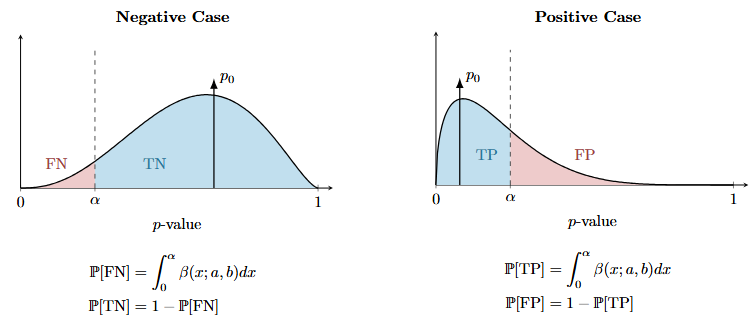

In [328]:
df = pd.read_csv(data_dir / "parkinson" / "Current" / "uncertainty_stats.csv")
df["significant"] = df["significant"].astype(bool)

df_sampled = df[df["group"] == "sampled"].copy()
df_sampled.rename(
    columns={
        "p_value": "Sampled p-value",
        "std_p": "Sampled p-value SD",
        "fraction_significant": "Fraction Significant",
        "card_significant": "Count Significant",
    },
    inplace=True,
)

alpha = 0.05
# Negative case
df_sampled["FN"] = np.where(
    ~df_sampled["significant"],
    flip_proba_beta(
        df_sampled["Sampled p-value"], df_sampled["Sampled p-value SD"], alpha=alpha
    ),
    0.0,
)
df_sampled["TN"] = np.where(
    ~df_sampled["significant"],
    1
    - flip_proba_beta(
        df_sampled["Sampled p-value"], df_sampled["Sampled p-value SD"], alpha=alpha
    ),
    0.0,
)
# Positive case
df_sampled["TP"] = np.where(
    df_sampled["significant"],
    flip_proba_beta(
        df_sampled["Sampled p-value"], df_sampled["Sampled p-value SD"], alpha=alpha
    ),
    0.0,
)
df_sampled["FP"] = np.where(
    df_sampled["significant"],
    1
    - flip_proba_beta(
        df_sampled["Sampled p-value"], df_sampled["Sampled p-value SD"], alpha=alpha
    ),
    0.0,
)

df_sampled["AP"] = df_sampled["TP"] + df_sampled["FN"]
df_sampled["AN"] = df_sampled["FP"] + df_sampled["TN"]
df_sampled["P"] = df_sampled["FN"] + df_sampled["TP"]
df_sampled["N"] = df_sampled["TN"] + df_sampled["FP"]
df_sampled["SEN"] = np.where(
    df_sampled["AP"] > 0, df_sampled["TP"] / df_sampled["AP"], 0
)
df_sampled["SPE"] = np.where(
    df_sampled["AN"] > 0, df_sampled["TN"] / df_sampled["AN"], 0
)
df_sampled["FPR"] = np.where(
    df_sampled["AN"] > 0, df_sampled["FP"] / df_sampled["AN"], 0
)
df_sampled["FDR"] = np.where(
    (df_sampled["FP"] + df_sampled["TP"]) > 0,
    df_sampled["FP"] / (df_sampled["FP"] + df_sampled["TP"]),
    0,
)
df_sampled["ACC"] = df_sampled["TP"] + df_sampled["TN"] 


## Simulated std p-values

In [329]:
df = pd.read_csv(data_dir / "parkinson" / "Current" / "uncertainty_stats.csv")
df["significant"] = df["significant"].astype(bool)

df_simulated = df[df["group"] == "simulated"].copy()
df_simulated.rename(
    columns={
        "p_value": "Sampled p-value",
        "std_p": "Simulated p-value SD",
        "fraction_significant": "Fraction Significant",
        "card_significant": "Count Significant",
    },
    inplace=True,
)

alpha = 0.05
# Negative case
df_simulated["FN"] = np.where(
    ~df_simulated["significant"],
    flip_proba_beta(
        df_simulated["Sampled p-value"], df_simulated["Simulated p-value SD"], alpha=alpha
    ),
    0.0,
)
df_simulated["TN"] = np.where(
    ~df_simulated["significant"],
    1
    - flip_proba_beta(
        df_simulated["Sampled p-value"], df_simulated["Simulated p-value SD"], alpha=alpha
    ),
    0.0,
)
# Positive case
df_simulated["TP"] = np.where(
    df_simulated["significant"],
    flip_proba_beta(
        df_simulated["Sampled p-value"], df_simulated["Simulated p-value SD"], alpha=alpha
    ),
    0.0,
)
df_simulated["FP"] = np.where(
    df_simulated["significant"],
    1
    - flip_proba_beta(
        df_simulated["Sampled p-value"], df_simulated["Simulated p-value SD"], alpha=alpha
    ),
    0.0,
)


df_simulated["AP"] = df_simulated["TP"] + df_simulated["FN"]
df_simulated["AN"] = df_simulated["FP"] + df_simulated["TN"]
df_simulated["P"] = df_simulated["FN"] + df_simulated["TP"]
df_simulated["N"] = df_simulated["TN"] + df_simulated["FP"]
df_simulated["SEN"] = np.where(
    df_simulated["AP"] > 0, df_simulated["TP"] / df_simulated["AP"], 0
)
df_simulated["SPE"] = np.where(
    df_simulated["AN"] > 0, df_simulated["TN"] / df_simulated["AN"], 0
)
df_simulated["FPR"] = np.where(
    df_simulated["AN"] > 0, df_simulated["FP"] / df_simulated["AN"], 0
)
df_simulated["FDR"] = np.where(
    (df_simulated["FP"] + df_simulated["TP"]) > 0,
    df_simulated["FP"] / (df_simulated["FP"] + df_simulated["TP"]),
    0,
)
df_simulated["ACC"] = df_simulated["TP"] + df_simulated["TN"]

## Standard-deviation comparison

- Sampled: Sample standard deviation from raw p-values
- Simulated: Square root of mean variances of sigma_p, where sigma_p are computed using uncertainty propagation formulae

In [340]:
subcortical_regions = [
    "Thalamus",
    "Caudate",
    "Putamen",
    "Pallidum",
    "Hippocampus",
    "Amygdala",
    "Accumbens-area",
]
subcortical_regions = (
    ["Left-" + region for region in subcortical_regions]
    + ["Right-" + region for region in subcortical_regions]
    + subcortical_regions
)

# Cortical regions in DKT atlas
cortical_regions = [
    "bankssts",
    "caudalanteriorcingulate",
    "caudalmiddlefrontal",
    "cuneus",
    "entorhinal",
    "fusiform",
    "inferiorparietal",
    "inferiortemporal",
    "isthmuscingulate",
    "lateraloccipital",
    "lateralorbitofrontal",
    "lingual",
    "medialorbitofrontal",
    "middletemporal",
    "parahippocampal",
    "paracentral",
    "parsopercularis",
    "parsorbitalis",
    "parstriangularis",
    "pericalcarine",
    "postcentral",
    "posteriorcingulate",
    "precentral",
    "precuneus",
    "rostralanteriorcingulate",
    "rostralmiddlefrontal",
    "superiorfrontal",
    "superiorparietal",
    "superiortemporal",
    "supramarginal",
    "frontalpole",
    "temporalpole",
    "transversetemporal",
    "insula",
]
cortical_regions = (
    ["lh-" + region for region in cortical_regions]
    + ["rh-" + region for region in cortical_regions]
    + cortical_regions
)
regions = cortical_regions + subcortical_regions

In [341]:
import plotly.graph_objects as go

colormap = {}
# Colorblind palette https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40
colormap["T"] = "#D81B60"
colormap["F"] = "#1E88E5"
colormap["R"] = "#FFC107"


df = pd.concat([df_sampled, df_simulated])
df = df.pivot_table(
    index=["region", "test", "metric", "study"],
    values=["Sampled p-value SD", "Simulated p-value SD"],
)
df.reset_index(inplace=True)
df["Sampled p-value SD"] = df["Sampled p-value SD"].clip(lower=1e-10)
df["Simulated p-value SD"] = df["Simulated p-value SD"].clip(lower=1e-10)
df.loc[df["test"] == "r", "test"] = "R"

fig = px.scatter(
    df[df["region"].isin(regions)],
    x="Sampled p-value SD",
    y="Simulated p-value SD",
    color="test",
    color_discrete_map=colormap,
    facet_row="metric",
    facet_col="study",
    facet_row_spacing=0.01,
    # log_x=True,
    # log_y=True,
    height=1200,
    width=1200 / 1.4,
    hover_name="region",
)
fig.add_trace(
    go.Scatter(
        x=[-1, 2], y=[-1, 2], mode="lines", line=dict(color="black", width=1), showlegend=False
    ),
    row="all",
    col="all",
)

fig.update_yaxes(exponentformat="power")
fig.update_xaxes(exponentformat="power")
nature_style(fig, width=fig.layout.width, height=fig.layout.height)

# 1. Remove the titles from the individual subplot axes
fig.update_xaxes(title=None)
fig.update_yaxes(title=None)

# 1. Disable standard axis titles
fig.update_layout(
    title="Sampled vs. simulated p-value standard deviation",
    title_x=0.5,
    xaxis_title="",
    yaxis_title="",
    margin=dict(l=80, b=80),
    legend=dict(
        x=0.85,
        y=-0.03,
        orientation="h",
        xanchor="center",
        yanchor="top",
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1,
    ),
)

fig.add_annotation(
    x=0.5,  # Center of the figure width
    y=-0.03,  # Position below the plot (adjust as needed)
    xref="paper",  # Use normalized coordinates (0-1)
    yref="paper",
    text="Sampled p-value standard deviation",
    showarrow=False,
    font=dict(size=16),  # Match your Nature-style font
    xanchor="center",
    yanchor="top",
)

fig.add_annotation(
    x=-0.04,  # Position to the left of the plot (adjust as needed)
    y=0.5,  # Center of the figure height
    xref="paper",
    yref="paper",
    text="Simulated p-value standard deviation",
    textangle=-90,  # Rotate vertical
    showarrow=False,
    font=dict(size=16),
    xanchor="right",
    yanchor="middle",
)

fig.update_layout(margin=dict(l=10, b=20, t=60, r=0))
fig.update_layout(title="Sampled vs. simulated p-value standard deviation", title_x=0.5)

fig

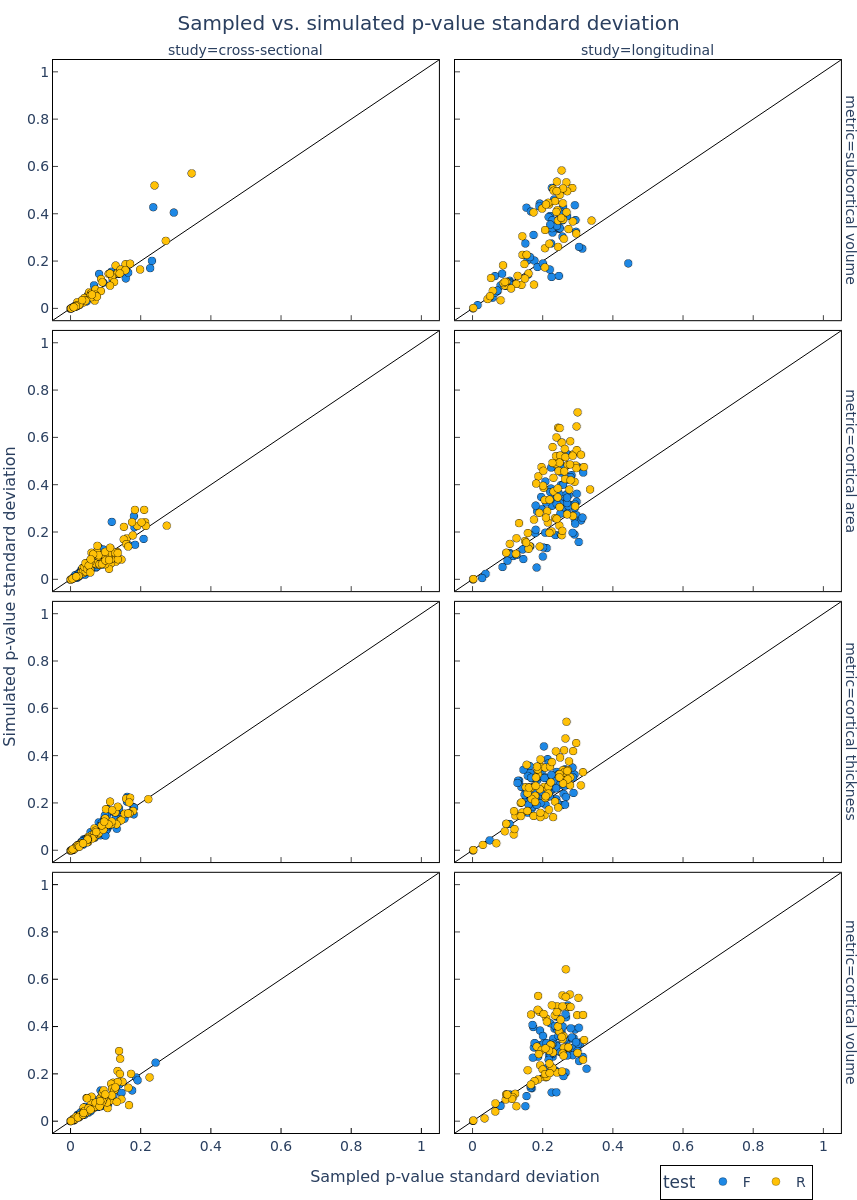

In [331]:
from IPython.display import Image, display

fig.write_image("std-sampled-simulated-comparison.pdf")
display(Image(fig.to_image()))

In [343]:
df = pd.concat([df_sampled, df_simulated])
df = df.pivot_table(
    index=["region", "test", "metric", "study"],
    columns=["group"],
    values=["TP", "FP", "TN", "FN", "P", "N", "AP", "ACC", "SEN", "SPE", "FPR", "FDR", "Fraction Significant"],
).reset_index()
df.columns = ["_".join(col).strip() if col[1] else col[0] for col in df.columns.values]

In [347]:
import plotly.graph_objects as go

colormap = {}
# Colorblind palette https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40
colormap["T"] = "#D81B60"
colormap["F"] = "#1E88E5"
colormap["R"] = "#FFC107"

df.loc[df["test"] == "r", "test"] = "R"

fig = px.scatter(
    df[df["region"].isin(regions)],
    x="P_simulated",
    y="Fraction Significant_sampled",
    facet_col="study",
    facet_row="metric",
    color="test",
    color_discrete_map=colormap,
    height=1200,
    width=1200 / 1.4,
    hover_data=["region"],
)
fig.add_trace(
    go.Scatter(
        x=[-1, 2], y=[-1, 2], mode="lines", line=dict(color="black", width=1), showlegend=False
    ),
    row="all",
    col="all",
)
nature_style(fig, width=fig.layout.width, height=fig.layout.height)
fig.update_layout(
    title="Sampled vs Simulated PPR",
    legend=dict(yanchor="top", y=1.05, xanchor="left", x=0.9, orientation="h"),
)


# 1. Remove the titles from the individual subplot axes
fig.update_xaxes(title=None)
fig.update_yaxes(title=None)

# 1. Disable standard axis titles
fig.update_layout(
    title="Sampled vs. simulated p-value standard deviation",
    title_x=0.5,
    xaxis_title="",
    yaxis_title="",
    margin=dict(l=80, b=80),
    legend=dict(
        x=0.85,
        y=-0.03,
        orientation="h",
        xanchor="center",
        yanchor="top",
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1,
    ),
)
# X axis
fig.add_annotation(
    x=0.5,  # Center of the figure width
    y=-0.03,  # Position below the plot (adjust as needed)
    xref="paper",  # Use normalized coordinates (0-1)
    yref="paper",
    text="Simulated positive prediction rate",
    showarrow=False,
    font=dict(size=16),  # Match your Nature-style font
    xanchor="center",
    yanchor="top",
)
# Y axis
fig.add_annotation(
    x=-0.04,  # Position to the left of the plot (adjust as needed)
    y=0.5,  # Center of the figure height
    xref="paper",
    yref="paper",
    text="Proportion of significant tests",
    textangle=-90,  # Rotate vertical
    showarrow=False,
    font=dict(size=16),
    xanchor="right",
    yanchor="middle",
)

fig.update_layout(margin=dict(l=10, b=20, t=60, r=0))
fig.update_layout(title="Proportion of significant tests vs. simulated positive prediction rate", title_x=0.501)

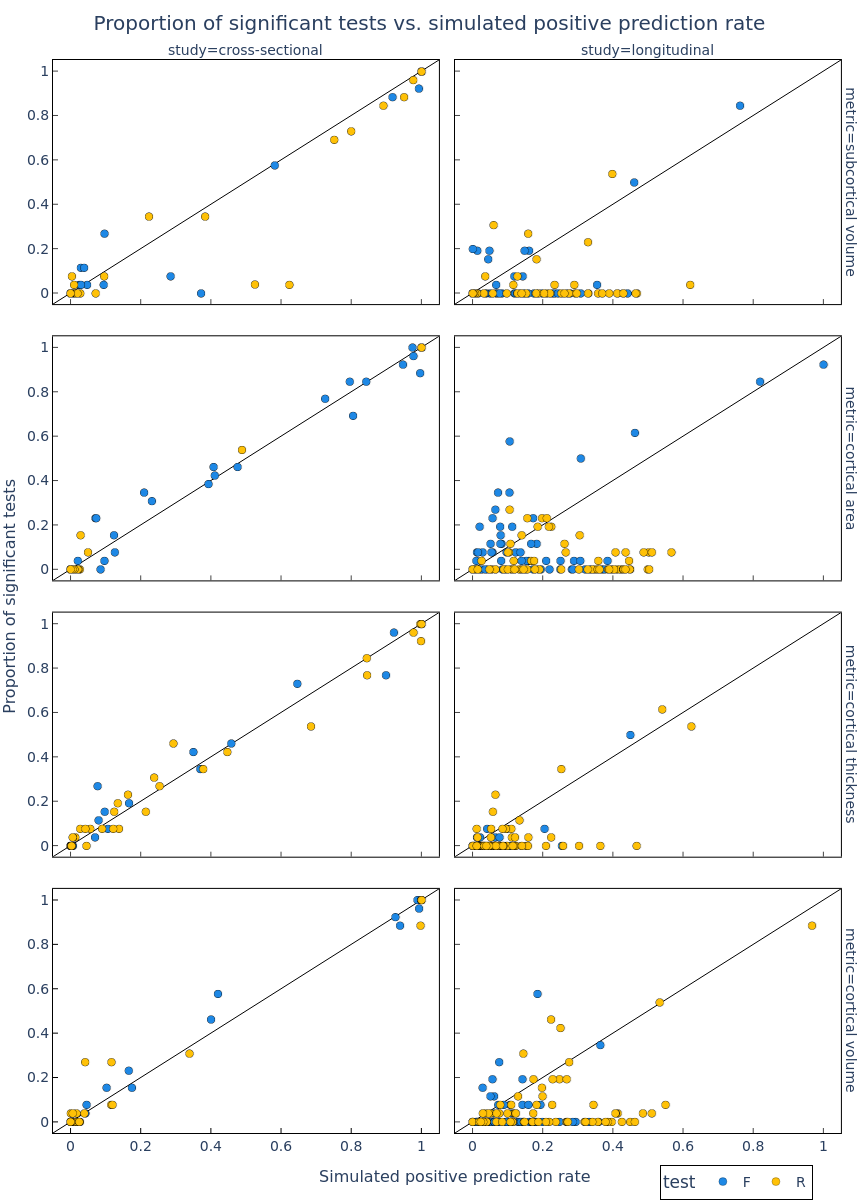

In [334]:
from IPython.display import Image, display

fig.write_image("ppr_simulated.pdf")
display(Image(fig.to_image()))

In [345]:
import plotly.graph_objects as go

colormap = {}
# Colorblind palette https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40
colormap["T"] = "#D81B60"
colormap["F"] = "#1E88E5"
colormap["R"] = "#FFC107"

df.loc[df["test"] == "r", "test"] = "R"

fig = px.scatter(
    df[df["region"].isin(regions)],
    x="P_sampled",
    y="Fraction Significant_sampled",
    facet_col="study",
    facet_row="metric",
    color="test",
    color_discrete_map=colormap,
    height=1200,
    width=1200 / 1.4,
)
fig.add_trace(
    go.Scatter(
        x=[-1, 2], y=[-1, 2], mode="lines", line=dict(color="black", width=1), showlegend=False
    ),
    row="all",
    col="all",
)

nature_style(fig, width=fig.layout.width, height=fig.layout.height)


# 1. Remove the titles from the individual subplot axes
fig.update_xaxes(title=None)
fig.update_yaxes(title=None)

# 1. Disable standard axis titles
fig.update_layout(
    title_x=0.5,
    xaxis_title="",
    yaxis_title="",
    margin=dict(l=80, b=80),
    legend=dict(
        x=0.85,
        y=-0.03,
        orientation="h",
        xanchor="center",
        yanchor="top",
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1,
    ),
)

# X axis
fig.add_annotation(
    x=0.5,  # Center of the figure width
    y=-0.03,  # Position below the plot (adjust as needed)
    xref="paper",  # Use normalized coordinates (0-1)
    yref="paper",
    text="Sampled positive prediction rate",
    showarrow=False,
    font=dict(size=16),  # Match your Nature-style font
    xanchor="center",
    yanchor="top",
)
# Y axis
fig.add_annotation(
    x=-0.04,  # Position to the left of the plot (adjust as needed)
    y=0.5,  # Center of the figure height
    xref="paper",
    yref="paper",
    text="Proportion of significant tests",
    textangle=-90,  # Rotate vertical
    showarrow=False,
    font=dict(size=16),
    xanchor="right",
    yanchor="middle",
)

fig.update_layout(margin=dict(l=10, b=20, t=60, r=0))
fig.update_layout(title="Proportion of significant tests vs. sampled positive prediction rate", title_x=0.501)


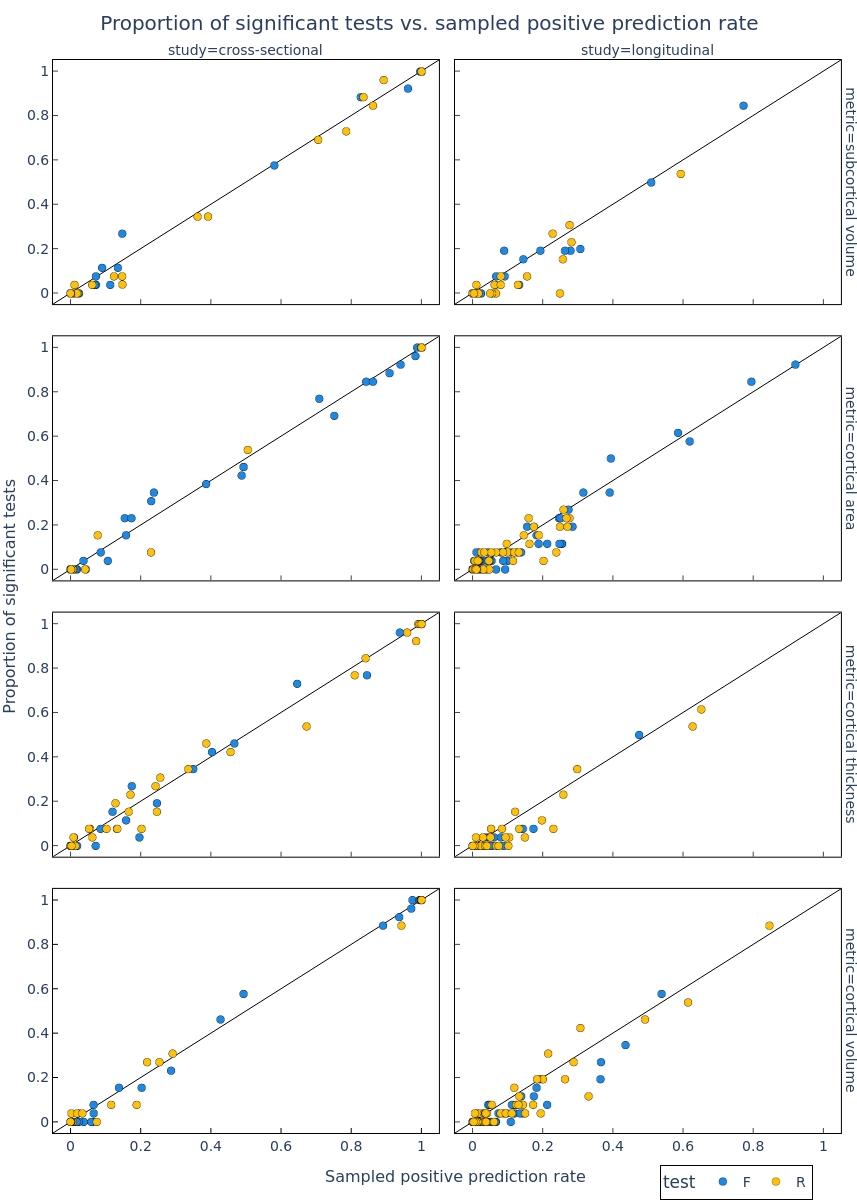

In [336]:
from IPython.display import Image, display

fig.write_image("ppr_sampled.pdf")
display(Image(fig.to_image()))